In [61]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tiktoken
from gpt2_models import GPT2Model
from gpt_download import download_and_load_gpt2
#from matplotlib.ticker import MaxNLocator
import urllib.request
import numpy as np
import zipfile
import os
from pathlib import Path
import pandas as pd
import time

#### SOURCE: [Raschka, Sebastian. Build a Large Language Model (From Scratch). Simon and Schuster, 2024.](https://www.simonandschuster.com/books/Build-a-Large-Language-Model-From-Scratch/Sebastian-Raschka/9781394200867)

### Classification Fine-Tuning

#### We can view a classification fine-tuned model as highly specialized, and generally, it is easier to develop a specialized model than a generalist model that works well across various tasks.

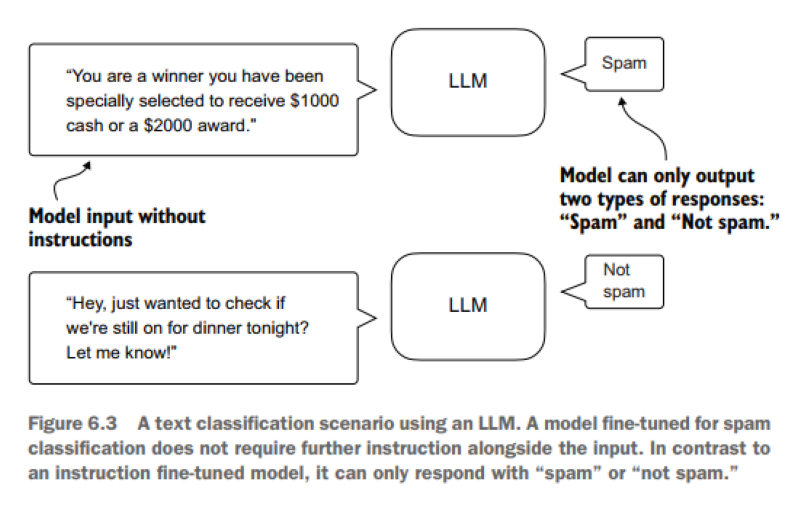

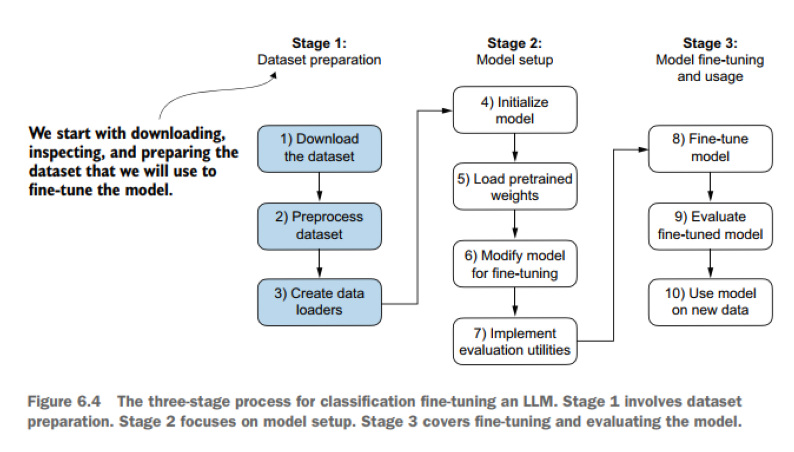

In [5]:
plt.figure(figsize=(10, 14))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\tune.png')
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 14))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\tune1.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [6]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

In [7]:
def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return
        
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
            
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
            
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [8]:
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [9]:
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [10]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [11]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])
    return balanced_df

In [12]:
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [13]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [14]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [15]:
# Split the dataset into three parts: 70% for training, 10% for validation, and 20% for testing. 
def random_split(df, train_frac, validation_frac):
    
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    
    return train_df, validation_df, test_df

In [16]:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [17]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

#### Creating data loaders
##### To batch these messages as we did with the text chunks, we have two primary options:

##### 1) Truncate all messages to the length of the shortest message in the dataset or batch.
##### 2) Pad all messages to the length of the longest message in the dataset or batch.

In [18]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


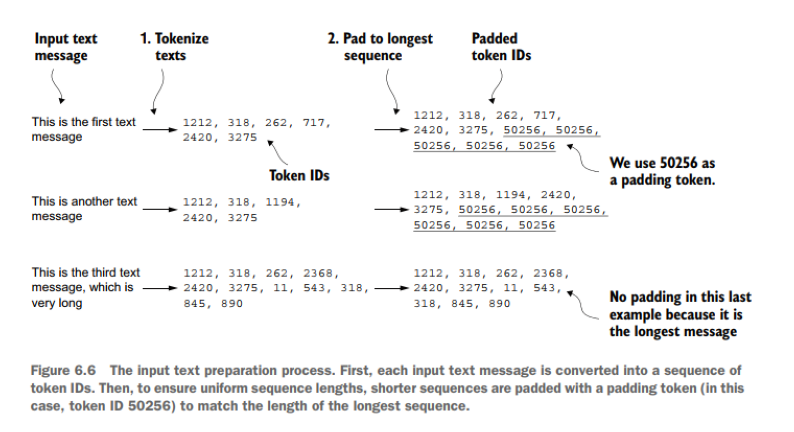

In [19]:
plt.figure(figsize=(10, 14))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\pad.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [20]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
        self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts] # Truncates sequences if they are longer than max_length
        self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts] # Pads sequences to the longest sequence
        
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
                
        return max_length

In [21]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [22]:
print(train_dataset.max_length)

120


In [23]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=None, # train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=None, # train_dataset.max_length,
    tokenizer=tokenizer
)

In [24]:
print(val_dataset.max_length)
print(test_dataset.max_length)

71
92


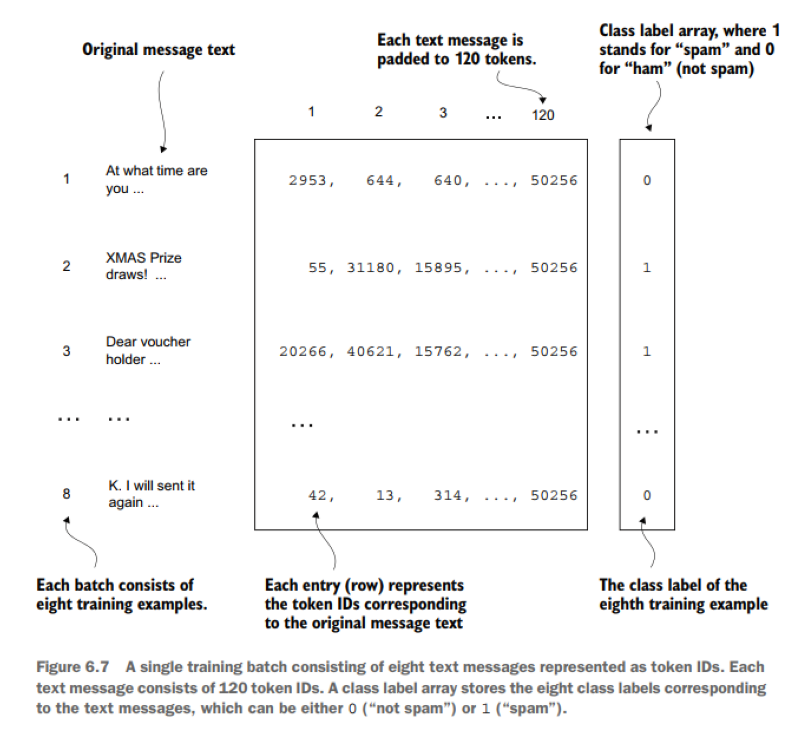

In [25]:
plt.figure(figsize=(10, 14))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\loader.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [26]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [27]:
#g = 0
for input_batch, target_batch in train_loader:
    pass
    #g += 1
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [28]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


#### Initializing a model with pretrained weights

In [29]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

In [30]:
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [31]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(
            f"Shape mismatch. Left: {left.shape}, "
            "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

In [32]:
def load_weights_into_gpt(gpt, params):
    
    gpt.position_embed.weight = assign(gpt.position_embed.weight, params['wpe'])
    gpt.token_embed.weight = assign(gpt.token_embed.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.weight = assign(
            gpt.transformer_blocks[b].attention.W_query.weight, q_w.T)
        gpt.transformer_blocks[b].attention.W_key.weight = assign(
            gpt.transformer_blocks[b].attention.W_key.weight, k_w.T)
        gpt.transformer_blocks[b].attention.W_value.weight = assign(
            gpt.transformer_blocks[b].attention.W_value.weight, v_w.T)
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transformer_blocks[b].attention.W_query.bias = assign(
            gpt.transformer_blocks[b].attention.W_query.bias, q_b)
        gpt.transformer_blocks[b].attention.W_key.bias = assign(
            gpt.transformer_blocks[b].attention.W_key.bias, k_b)
        gpt.transformer_blocks[b].attention.W_value.bias = assign(
            gpt.transformer_blocks[b].attention.W_value.bias, v_b)
        gpt.transformer_blocks[b].attention.out_projection.weight = assign(
            gpt.transformer_blocks[b].attention.out_projection.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].attention.out_projection.bias = assign(
            gpt.transformer_blocks[b].attention.out_projection.bias,
        params["blocks"][b]["attn"]["c_proj"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[0].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[0].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_blocks[b].feed_forward.layers[2].weight = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_blocks[b].feed_forward.layers[2].bias = assign(
            gpt.transformer_blocks[b].feed_forward.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])
        gpt.transformer_blocks[b].norm1.scale = assign(
            gpt.transformer_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_blocks[b].norm1.shift = assign(
            gpt.transformer_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_blocks[b].norm2.scale = assign(
            gpt.transformer_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_blocks[b].norm2.shift = assign(
            gpt.transformer_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])
        
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.linear_transform.weight = assign(gpt.linear_transform.weight, params["wte"])

In [33]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPT2Model(
    vocab_size=BASE_CONFIG['vocab_size'],
    embed_dim=BASE_CONFIG['emb_dim'],
    context_length=BASE_CONFIG['context_length'],
    dropout_rate=BASE_CONFIG['drop_rate'],
    num_layer=BASE_CONFIG['n_layers'],
    num_heads=BASE_CONFIG['n_heads'],
    qkv_bias=BASE_CONFIG['qkv_bias']
)

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [34]:
load_weights_into_gpt(model, params)
model.eval()

GPT2Model(
  (token_embed): Embedding(50257, 768)
  (position_embed): Embedding(1024, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): Transformer(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): Transformer(
      (attention): MultiHeadAttention(
  

In [35]:
def text_to_token_ids(text, tokenizer):
    
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # .unsqueeze(0) adds the batch dimension
    
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    
    flat = token_ids.squeeze(0) # Removes batch dimension
    
    return tokenizer.decode(flat.tolist())

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        
        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
            
        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
        
    return idx

In [36]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to("cpu"),
    max_new_tokens=300,
    context_size=BASE_CONFIG['context_length'],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you to the other."<|endoftext|>This pattern is NOT A SKULLY Sized (I got it right up to 36in x 32.5in unless listed so the measurements are exact). It looks like you could sew a bit more tightly than before with an equal sized yarn, however, no matter how much more than the size it will keep slipping and tearing if the gauge is really tight at all. The colors should vary slightly and the colors in this tutorial won't really come off either way once you put the needles where they hold in the needlehole. If it feels a little dry you are going wrong...I used 8 and a half inch wide spun yarn and the rest came off naturally, I do feel this will vary, depending on how much more you mix them up...it might even keep getting stretched out, which hurts even if someone puts as much of a pressure on it as you might for it being more difficult than what looks good. I suggest just putting it on 1 inch and going straight through the needle or you might fall off in one

In [37]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer).to("cpu"),
    max_new_tokens=23,
    context_size=BASE_CONFIG['context_length'],
    top_k=1,
    temperature=0.0
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


In [38]:
# Based on the output, it’s apparent that the model is struggling to follow instructions.
# This result is expected, as it has only undergone pretraining and lacks instruction
# fine-tuning. So, let’s prepare the model for classification fine-tuning.

#### Adding a classification head

##### We must modify the pretrained LLM to prepare it for classification fine-tuning. To do so, we replace the original output layer, which maps the hidden representation to a vocabulary of 50,257, with a smaller output layer that maps to two classes: 0 (“not spam”) and 1 (“spam”).

##### Since we start with a pretrained model, it’s not necessary to fine-tune all model layers. In neural network-based language models, the lower layers generally capture basic language structures and semantics applicable across a wide range of tasks and datasets. So, fine-tuning only the last layers (i.e., layers near the output), which are more specific to nuanced linguistic patterns and task-specific features, is often sufficient to adapt the model to new tasks. A nice side effect is that it is computationally more efficient to finetune only a small number of layers. 

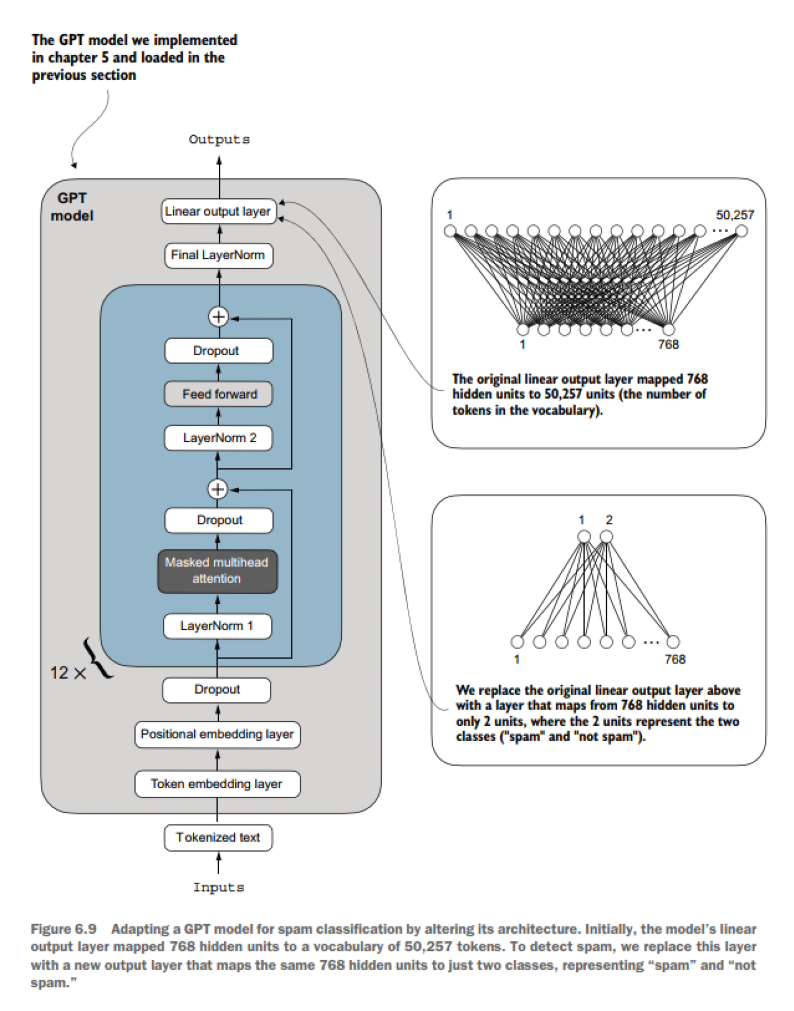

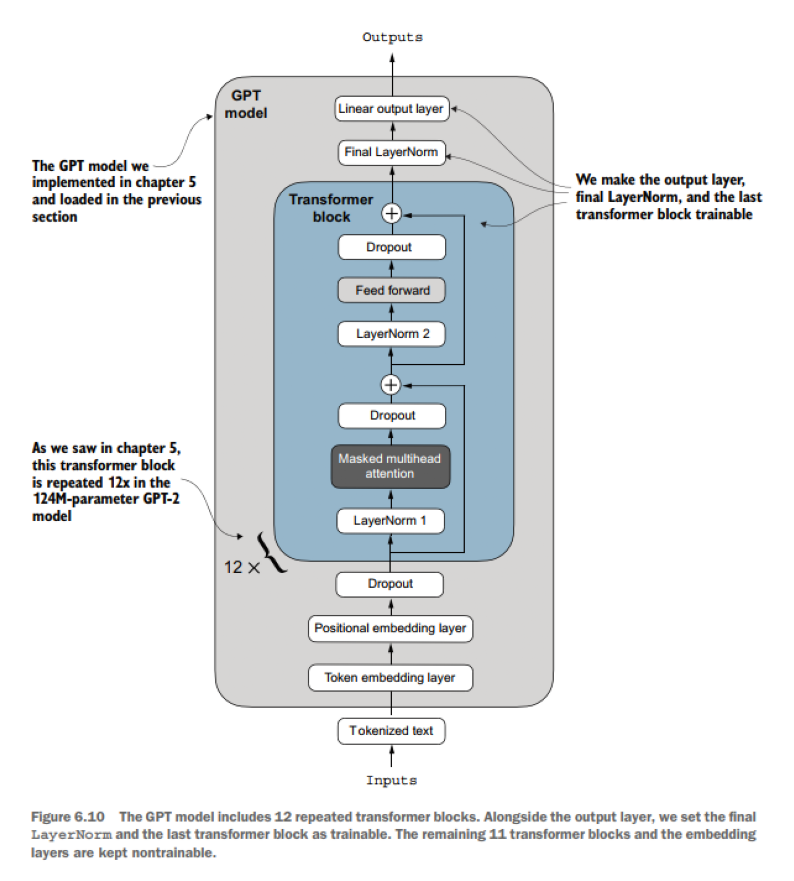

In [39]:
plt.figure(figsize=(10, 14))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\last-layer.png')
plt.imshow(img)
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 14))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\last-layer1.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [40]:
print(model)

GPT2Model(
  (token_embed): Embedding(50257, 768)
  (position_embed): Embedding(1024, 768)
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer_blocks): Sequential(
    (0): Transformer(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_projection): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): Transformer(
      (attention): MultiHeadAttention(
  

In [41]:
# freeze the model
for param in model.parameters():
    param.requires_grad = False

In [42]:
torch.manual_seed(123)
num_classes = 2
model.linear_transform = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)# This new model.linear_transform output layer has its requires_grad attribute set to
 # True by default, which means that it’s the only layer in the model that will be
 # updated during training (fine tuning). 

In [43]:
for param in model.transformer_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

In [44]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [45]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


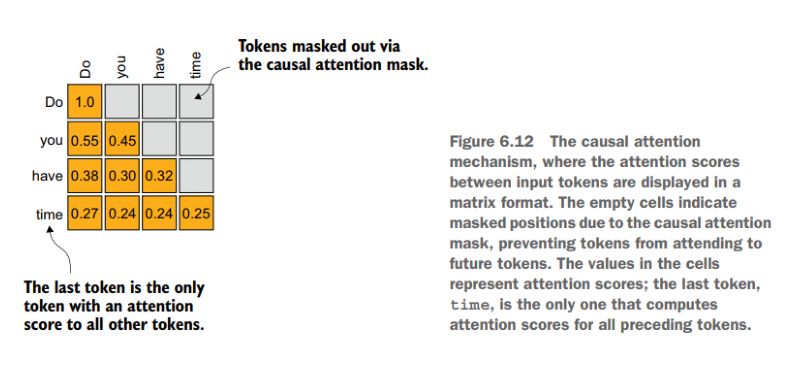

In [47]:
plt.figure(figsize=(10, 14))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\lastl.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [48]:
# Given the causal attention mask setup in figure above,
# the last token in a sequence accumulates the most information
# since it is the only token with access to data from all the
# previous tokens. Therefore, in our spam classification task, we focus on this last token
# during the fine-tuning process.

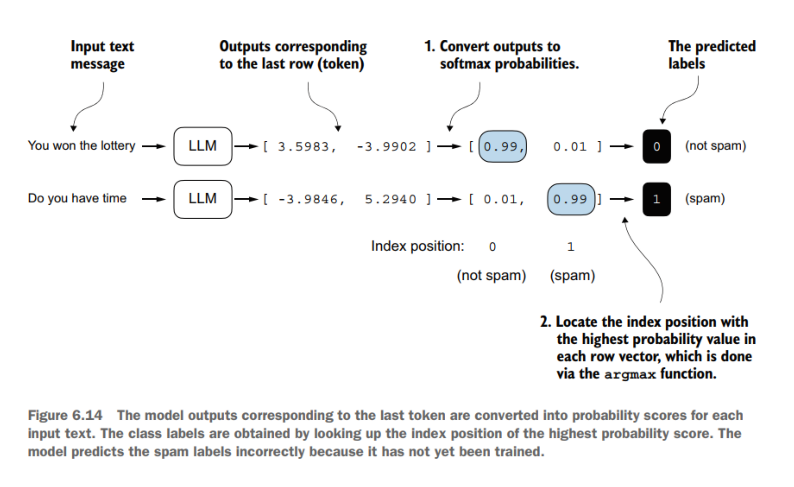

In [49]:
plt.figure(figsize=(10, 14))
img = mpimg.imread(r'C:\Users\yda2\Desktop\llms\spam-detection.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [50]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [51]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


In [54]:
# Calculating the classification accuracy
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :] # Logits of last output token
                predicted_labels = torch.argmax(logits, dim=-1)
                num_examples += predicted_labels.shape[0]
                correct_predictions += (
                    (predicted_labels == target_batch).sum().item()
                )
        else:
            break
    return correct_predictions / num_examples

In [53]:
device = torch.device("cpu")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [55]:
def calc_loss_batch(input_batch, target_batch, model, device):
    
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    
    return loss    

In [57]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
            
    return total_loss / num_batches

In [58]:
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
    
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.525
Test loss: 2.413


In [59]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )
                
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [60]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    
    return train_loss, val_loss

In [62]:
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.351
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.624
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.602
Training accuracy: 70.00% | Validation accuracy: 82.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.465
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.542
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.520
Training accuracy: 82.50% | Validation accuracy: 72.50%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.473
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.426
Training accuracy: 90.00% | Validation accuracy: 82.50%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.325
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.231
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.249
Training accuracy: 100.00% | Validation accuracy: 90.00%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.250
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.133
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 34.59 m

In [63]:
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

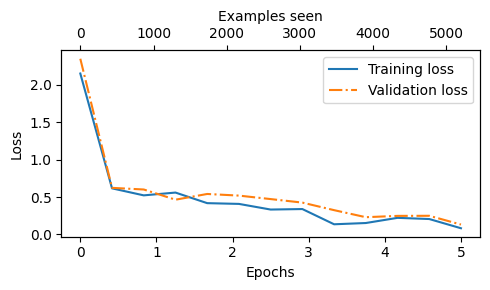

In [64]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

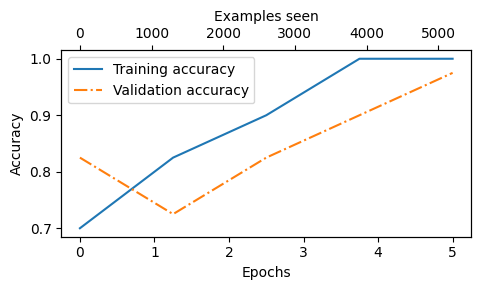

In [65]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [66]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 95.97%
Test accuracy: 96.33%


In [69]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    
    model.eval()
    input_ids = tokenizer.encode(text)
    supported_context_length = model.position_embed.weight.shape[1]
    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)
    
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()
    
    return "spam" if predicted_label == 1 else "not spam"

In [70]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [71]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [72]:
torch.save(model.state_dict(), "review_classifier.pth") # save the model

In [77]:
model_state_dict = torch.load("review_classifier.pth, map_location=device") # load the model
model.load_state_dict(model_state_dict)

FileNotFoundError: [Errno 2] No such file or directory: 'review_classifier.pth, map_location=device'